# Preparation

In [5]:
# Preperation

try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/'.format(shared_drive_foldername)
  subject_figures_path = root + "4. Results/1. Subject level/"
  %pip install pandas==1.4.2
  print('Running Code in Colab')
except:
  root = 'D:/FV/Projects/NUTRECON/nutreconDrive/'
  subject_figures_path = "D:/FV/Projects/NUTRECON/Results/Subject Level/"
  print('Running Code locally')

import pandas as pd
import numpy as np
from datetime import datetime
from glob import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
#from sklearn.linear_model import LogisticRegression
from numpy.core.fromnumeric import resize
from pathlib import Path


sys.path.append(root + '1. Acquisition/notebooks')

from nutrecon import *

subject_nr = 1

_v_ = Vars()

experiment_code = _v_.experiment_code
dataPath = _v_.dataPath
sequences_dataPath = _v_.sequences_dataPath
responses_dataPath = _v_.responses_dataPath

subject_code = '{}{:03d}'.format(experiment_code, subject_nr)

subject_figures_path_ = subject_figures_path + subject_code
Path(subject_figures_path_).mkdir(parents=True, exist_ok=True)

flavorCodes = _v_.flavorCodes

imageCodes = _v_.imageCodes

imageDecoder = _v_.imageDecoder

pres_order_fileID = _v_.pres_order_fileID
pres_order_colName = _v_.pres_order_colName
flavorName_colName = _v_.flavorName_colName
flavorID_colName = _v_.flavorID_colName

pres_order_d2_fileID = _v_.pres_order_d2_fileID
pres_order_d3_fileID = _v_.pres_order_d3_fileID

flav_ratings_fileID = _v_.flav_ratings_fileID

intensity_colName = _v_.intensity_colName
novelty_colName = _v_.novelty_colName
pleasanteness_colName = _v_.pleasanteness_colName

learn_order_fileID = _v_.learn_order_fileID
learningOrder_colName = _v_.learningOrder_colName
imageName_colName = _v_.imageName_colName
imageID_colName = _v_.imageID_colName

assocTestOrder1_colName = _v_.assocTestOrder1_colName
assoc1_order_fileID = _v_.assoc1_order_fileID

assocTestOrder2_colName = _v_.assocTestOrder2_colName
assoc2_order_fileID = _v_.assoc2_order_fileID

assocTestOrder3_colName = _v_.assocTestOrder3_colName
assoc3_order_fileID = _v_.assoc3_order_fileID

neuroEconOrder1_fileID = _v_.neuroEconOrder1_fileID
neuroEconOrder2_fileID = _v_.neuroEconOrder2_fileID

conditioning_order_fileID = _v_.conditioning_order_fileID
conditioning_order_colName = _v_.conditioning_order_colName

ratings_id = _v_.ratings_id
orders_id = _v_.orders_id


learning_path = glob('{}{}*{}*'.format(sequences_dataPath, subject_code, learn_order_fileID))[0]

learnig_df = pd.read_json(learning_path).T
learnig_df[flavorName_colName].tolist()

neuroEcon_id = _v_.neuroEcon_id

neuroEcon_df = pd.read_json(glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))[0])
flavor_Cplus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['reference flavor']
flavor_Cminus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['lottery flavor']

marker_order = ['^' if flavor == flavor_Cplus else 'v' if flavor == flavor_Cminus else 'o' if flavor in learnig_df[flavorName_colName].tolist() else 'x' for flavor in list(flavorCodes.keys())]

Running Code locally


# Ratings

c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.7686274509803922, 0.3058823529411765, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.5058823529411764, 0.4470588235294118, 0.7019607843137254)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor 

Text(0.5, 0.98, 'Variación de las clasificaciones de novedad, intensidad y agradabilidad')

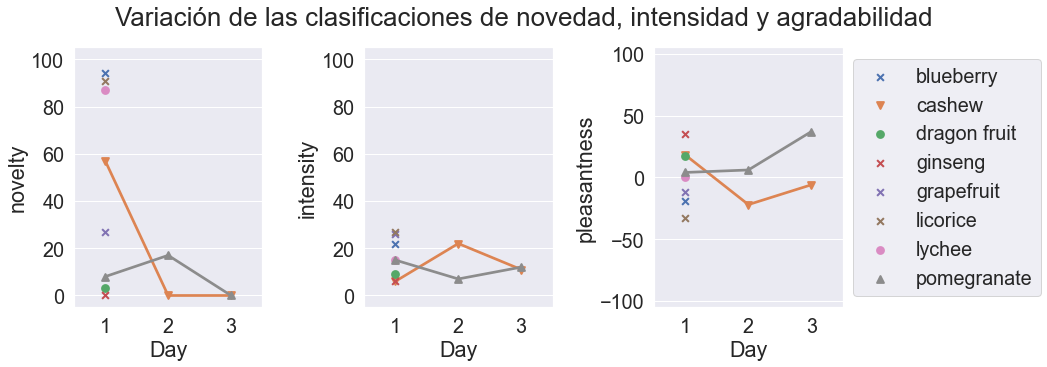

In [6]:


ratings_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, ratings_id))


marker_scale = 1
for ratings_path in ratings_paths:
  dayRating_df = pd.read_json(ratings_path)
  fpath, day, preOrder, timestamp =  ratings_path.split('_')
  order_path = glob('{}_{}{}*'.format(fpath.replace('responses', 'sequences'), day, orders_id))[0]
  dayOrder_df = pd.read_json(order_path).T
  dayOrder_df['Trial'] = np.arange(len(dayOrder_df)) + 1
  dayRating_df = dayRating_df.merge(dayOrder_df[[flavorName_colName, flavorID_colName, 'Trial']], left_on = 'Trial', right_on = 'Trial')
  if ratings_path == ratings_paths[0]:
    ratings_df = dayRating_df
  else:
    ratings_df = pd.concat([ratings_df, dayRating_df])

sns.set_theme(font_scale = 1.8)
fig, ax = plt.subplots(ncols = 3, figsize = [15,5])

sns.pointplot(data = ratings_df, x = 'Day', y = novelty_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[0], legend = False)
ax[0].set_ylim([-5,105]);
ax[0].get_legend().remove();

sns.pointplot(data = ratings_df, x = 'Day', y = intensity_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[1])
ax[1].set_ylim([-5,105]);
ax[1].get_legend().remove();

sns.pointplot(data = ratings_df, x = 'Day', y = pleasanteness_colName, hue = flavorName_colName, hue_order = list(flavorCodes.keys()),
              markers = marker_order, scale=marker_scale, order = [1,2,3], ax = ax[2])
ax[2].set_ylim([-105,105]);
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

fig.savefig(subject_figures_path_ + '/ratings.png')
fig.suptitle('Variación de las clasificaciones de novedad, intensidad y agradabilidad', va= 'bottom')



# Association Tests

			Accuracy: 0.8333333333333334


precision    recall  f1-score        Flavor
criteria      image_id flavor_id                                             
in compliance Image II c           1.000000  1.000000  1.000000        cashew
              Image I  e           0.857143  1.000000  0.923077   pomegranate
              Image V  d           0.800000  0.666667  0.727273        lychee
              Image VI h           0.666667  0.666667  0.666667  dragon fruit

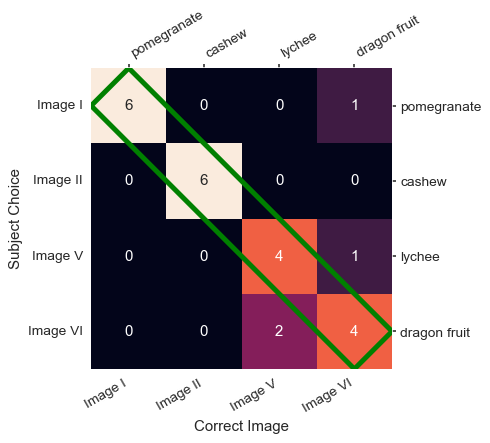

In [7]:
sns.set_theme(font_scale = 1)

min_correctResp = 4
associationTest1_df, _ = loadResponses(sequences_dataPath, assoc1_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day1_sequence = [get_key(imageDecoder,p) for p in associationTest1_df.T['image_id'].tolist()]
atest_day1_responses, _ = loadResponses(responses_dataPath, 'day1_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day1_sequence, atest_day1_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig(subject_figures_path_ + '/atest1.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

			Accuracy: 1.0


precision  recall  f1-score       Flavor
criteria      image_id flavor_id                                          
in compliance Image I  e                1.0     1.0       1.0  pomegranate
              Image II c                1.0     1.0       1.0       cashew

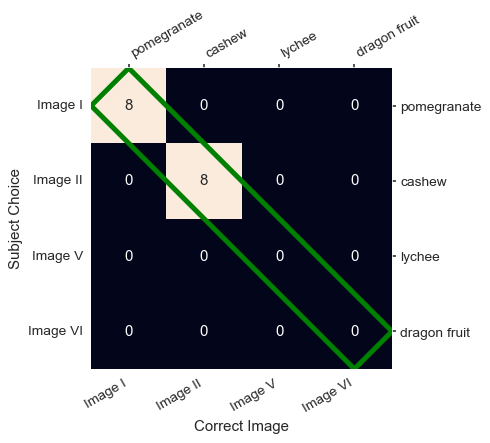

In [8]:
min_correctResp = 7
associationTest2_df, _ = loadResponses(sequences_dataPath, assoc2_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day2_sequence = [get_key(imageDecoder,p) for p in associationTest2_df.T['image_id'].tolist()]
atest_day2_responses, _ = loadResponses(responses_dataPath, 'day2_atest', subject_code)

fig, report = reportAndConfusionMatrix(atest_day2_sequence, atest_day2_responses['image_id'].tolist(), flavorImage_code)
plt.tight_layout()
fig.savefig(subject_figures_path_ + '/atest2.png', transparent=True)
check_atest(report, flavorImage_code, min_correctResp)

			Accuracy: 1.0


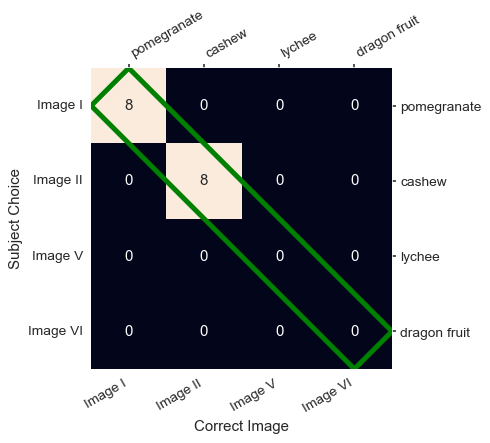

In [9]:
min_correctResp = 7

associationTest3_df, _ = loadResponses(sequences_dataPath, assoc3_order_fileID, subject_code)
imageFlavor_df, _ = loadResponses(sequences_dataPath, learn_order_fileID, subject_code)
flavorImage_code = {p[imageID_colName]:p[flavorName_colName] for p in imageFlavor_df.T[[imageID_colName, flavorName_colName]].to_dict('index').values()}
atest_day3_sequence = [get_key(imageDecoder,p) for p in associationTest3_df.T['image_id'].tolist()]
atest_day3_responses, _ = loadResponses(responses_dataPath, 'day3_atest', subject_code)

if _ != None:
  fig, report = reportAndConfusionMatrix(atest_day3_sequence, atest_day3_responses['image_id'].tolist(), flavorImage_code)
  plt.tight_layout()
  fig.savefig(subject_figures_path_ + '/atest3.png', transparent=True)
  check_atest(report, flavorImage_code, min_correctResp)

# Reaction times

In [10]:
neuroEcon_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))
neuroEcon_path = neuroEcon_paths[0]

for neuroEcon_path in neuroEcon_paths:
  dayNeuroEcon_df = pd.read_json(neuroEcon_path)
  if neuroEcon_path == neuroEcon_paths[0]:
    neuroEcon_df = dayNeuroEcon_df
  else:
    neuroEcon_df = pd.concat([neuroEcon_df, dayNeuroEcon_df])
neuroEcon_df['reaction_time'] = neuroEcon_df['choiceTime_ms'] - neuroEcon_df['choiceStart_ms']
neuroEcon_df['Day'] = neuroEcon_df['Day'].apply(lambda day: int(day[-1]))

neuroEcon_df.columns



Index(['Day', 'Trial', 'Trial ID', 'Trial Type', 'User', 'block', 'choice',
       'choiceStart_ms', 'choiceTime', 'choiceTime_ms', 'feedbackTime',
       'lottery flavor', 'lottery p', 'lottery qt', 'lottery shape',
       'lottery type', 'optionTime', 'reference flavor', 'reference p',
       'reference qt', 'reference shape', 'reference type',
       'trialStartTimestamp', 'trialStart_ms', 'reaction_time'],
      dtype='object')

c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

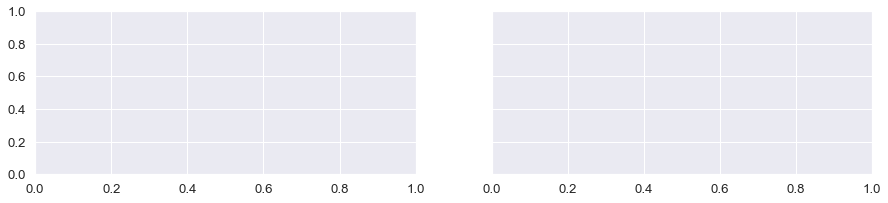

In [11]:
sns.set_theme(font_scale = 1.2)
fig, ax = plt.subplots(ncols = 2, figsize = [15,3], sharey = True, sharex = True)
c = 0
for day in neuroEcon_df['Day'].unique():
  sns.histplot(data = neuroEcon_df[neuroEcon_df['Day'] == day], x = 'reaction_time', ax = ax[c])
  ax[c].set_title('Day {}'.format(day))
  c+=1
plt.tight_layout()
fig.savefig(subject_figures_path_ + '/reaction_time.png')

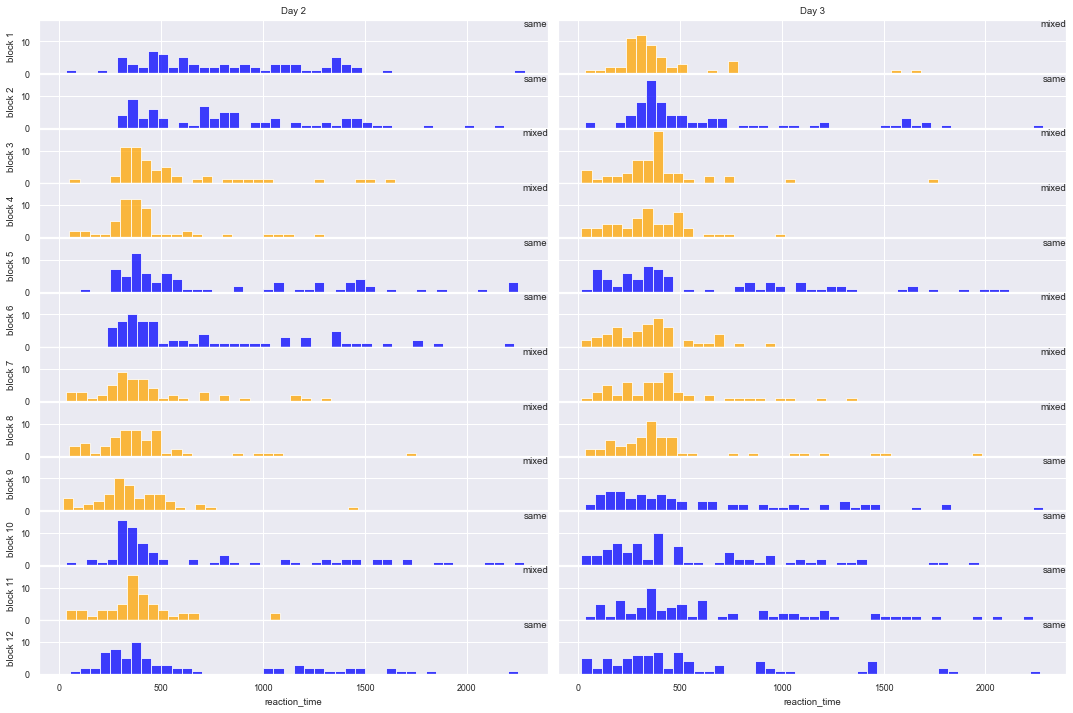

In [ ]:
sns.set_theme(font_scale = .8)
fig, ax = plt.subplots(ncols = 2, nrows = len(neuroEcon_df['block'].unique()), figsize = [15,10], sharex = True, sharey = True)

row = 0

for block in neuroEcon_df['block'].unique():
  df_ = neuroEcon_df[neuroEcon_df['block'] == block]  
  col = 0
  for day in df_['Day'].unique():
    block_type = df_[df_['Day'] == day]['Trial Type'].tolist()[0]
    if block_type == 'same':
      color = 'blue'
    else:
      block_type = 'mixed'
      color = 'orange'
    sns.histplot(data = df_[df_['Day'] == day], x = 'reaction_time', ax = ax[row, col],  binwidth=50, color = color)
    ax[row,col].set_ylabel('')
    ax[row,col].text(1,1,block_type, ha='right', va = 'top', transform = ax[row,col].transAxes)
    col+=1
  ax[row,0].set_ylabel('block {}'.format(block + 1))
    
  row += 1

ax[0,0].set_title('Day 2')
ax[0,1].set_title('Day 3')
plt.tight_layout(h_pad = -.5)
fig.savefig(subject_figures_path_ + '/block_reactionTime.png')

## missed trials

In [ ]:
zero_counts_df = pd.DataFrame()
try:
  answer_counts_df = pd.DataFrame(neuroEcon_df[['Day', 'Trial Type', 'lottery type','choice']].groupby(['Day', 'Trial Type', 'lottery type']).value_counts(), columns=['count'])
  zero_counts_df = answer_counts_df[answer_counts_df.index.get_level_values('choice') == 0]
except Exception as e:
  print(e)
zero_counts_df

count
Day Trial Type lottery type choice       
2   same       C+           0           2
               C-           0           3
3   same       C+           0           1
               C-           0           1

# Parameter estimation

## Same-Type

In [ ]:
column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr']

optimize_cols = column_names[:6]  + [column_names[12]]

def get_EU_(p,X, alpha):
  return p * X**alpha

def get_pL_(euL, euR, beta):
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))


def get_likelihood(row, params, cols = optimize_cols):
  ref_type = row[cols[0]]
  lott_type = row[cols[3]]
  if len(params) == 4:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
  elif len(params) == 6:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta_money, beta_Cplus, beta_Cminus) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    betas = {'money' : beta_money,
             'C+' : beta_Cplus,
             'C-' : beta_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
    beta = betas[lott_type]
  
  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  ref_EU = get_EU_(ref_p, ref_X, ref_alpha)
  
  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  lott_EU = get_EU_(lott_p, lott_X, lott_alpha)

  pL = get_pL_(lott_EU, ref_EU, beta)
  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  return likelihood

def get_negLogLikelihood(params, args):

  df = args
  task_cols = optimize_cols
  # compute likelihood of each choice
  likelihood = df.apply(lambda row: get_likelihood(row, params, cols = task_cols), axis=1).values
  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))
  return negloglikelihood

alpha_cPlus_d2 = 0
alpha_cMinus_d2 = 0
alpha_money_d2 = 0
alpha_cPlus_d3 = 0
alpha_cMinus_d3 = 0
alpha_money_d3 = 0
  
optimize_cols

['reference type',
 'reference qt',
 'reference p',
 'lottery type',
 'lottery qt',
 'lottery p',
 'choice']

In [ ]:
# ==========================================
#                   Day 2
# ==========================================
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0
beta0 = 0

df_day2 = neuroEcon_df[neuroEcon_df['Day'] == 2]

df_sameType = df_day2[df_day2['Trial Type'] == 'same']
df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)

args = (df_sameType)
x0 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)
res = minimize(get_negLogLikelihood, x0, args=args )

parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

alpha_money_d2 = parsCI[0]
alpha_cPlus_d2 = parsCI[1]
alpha_cMinus_d2 = parsCI[2]

# ==========================================
#                   Day 3
# ==========================================
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0
beta0 = 0

df_day3 = neuroEcon_df[neuroEcon_df['Day'] == 3]

if len(df_day3) > 0:
  df_sameType = df_day3[df_day3['Trial Type'] == 'same']
  df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)
  
  args = (df_sameType)
  x0 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)
  res = minimize(get_negLogLikelihood, x0, args=args )

  parsCI_d3 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  alpha_money_d3 = parsCI_d3[0]
  alpha_cPlus_d3 = parsCI_d3[1]
  alpha_cMinus_d3 = parsCI_d3[2]

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI[0]))
  print('  - {}: {}'.format('alpha C+', parsCI[1]))
  print('  - {}: {}'.format('alpha C-', parsCI[2]))
  print('  - {}: {}'.format('beta', parsCI[3]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d3[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d3[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d3[2]))
  print('  - {}: {}'.format('beta', parsCI_d3[3]))
else:
  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI[0]))
  print('  - {}: {}'.format('alpha C+', parsCI[1]))
  print('  - {}: {}'.format('alpha C-', parsCI[2]))
  print('  - {}: {}'.format('beta', parsCI[3]))
  print('\nDay 3 responses not loaded')

C:\Users\Admin\AppData\Local\Temp\ipykernel_2404\4265487746.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sameType['choice'] = np.where(df_sameType['choice'] == 2, 1, 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2404\1829766092.py:63: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
C:\Users\Admin\AppData\Local\Temp\ipykernel_2404\1829766092.py:63: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
c:\Users\Admin\anaconda3\envs\nutrecon\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp\ipykernel_2404\1829766092.py:63: RuntimeWarnin


Day 2 parameters:
  - alpha Money: 0.783 ± 0.159
  - alpha C+: 0.728 ± 0.068
  - alpha C-: -0.678 ± 1.382
  - beta: 0.74 ± 0.286

Day 3 parameters:
  - alpha Money: 0.783 ± 0.159
  - alpha C+: 0.728 ± 0.068
  - alpha C-: -0.678 ± 1.382
  - beta: 0.74 ± 0.286


# NeuroEcon choice plots
# Same-type trials


NameError: name 'alpha_cPlus_d2' is not defined

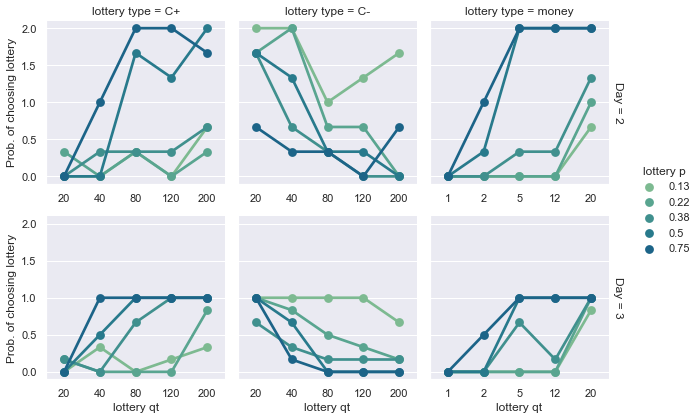

In [12]:


def get_reward_choice(row):
  if row['choice'] == 1:
    reward = row['reference type']
  elif row['choice'] == 2:
    reward = row['lottery type']
  else:
    reward = ''

  return reward

def get_choice_side(row):
  if row['choice'] == 1:
    reward = 'reference'
  elif row['choice'] == 2:
    reward = 'lottery'
  else:
    reward = ''

  return reward

def get_probLottery(group):
  prob_lotteryChoice = len(group[group['choice'] == 2]) / 6
  return prob_lotteryChoice

def plot_st_recap(df, st_color):

  fig, ax = plt.subplots(figsize = [3,3])
  sns.countplot(data=df, x='chosen option', order = ['reference', 'lottery'], palette=[tuple(c*.5 for c in st_color), st_color]);
  plt.tight_layout()
  #fig.savefig('mixedYogurt_choicesD2.png')


  grid = sns.FacetGrid(data=df, row = 'lottery qt', col = 'lottery p',height=2,aspect=1, margin_titles = True, sharey = True)
  fig = grid.map_dataframe(sns.countplot, x='chosen option', order = ['reference', 'lottery'], palette=[tuple(c*.5 for c in st_color), st_color])
  fig.add_legend()
  plt.tight_layout()


neuroEcon_df['chosen reward'] = neuroEcon_df.apply(lambda row: get_reward_choice(row), axis = 1)
neuroEcon_df['chosen option'] = neuroEcon_df.apply(lambda row: get_choice_side(row), axis = 1)


c_palette = sns.color_palette()

cPlus_color = c_palette[0]
cMinus_color = c_palette[1]
money_color = c_palette[2]

neuroEcon_st_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'same']

grouped_st_df = pd.DataFrame(neuroEcon_st_df.groupby(['Day', 'lottery type', 'lottery p', 'lottery qt']).apply(lambda df: get_probLottery(df)), 
        columns = [probLotteryChoice_colName]).reset_index()
sns.set_theme(font_scale = 1)

fg = sns.catplot(data= grouped_st_df, row = 'Day', col="lottery type", 
    x="lottery qt", y=probLotteryChoice_colName, hue="lottery p", 
    kind = 'point', palette = sns.color_palette("crest"),
    height=3, aspect = 1,
    sharex=False, margin_titles = True
    )

alpha_label = [r'$\alpha_{C\plus}= $', r'$\alpha_{C\minus}= $', r'$\alpha_{money}= $',
               r'$\alpha_{C\plus}= $', r'$\alpha_{C\minus}= $', r'$\alpha_{money}= $']
alpha_values = [alpha_cPlus_d2 ,alpha_cMinus_d2, alpha_money_d2,
                alpha_cPlus_d3 ,alpha_cMinus_d3, alpha_money_d3, ]
c = 0
for ax in fg.axes.flat:  # iterate through each subplot
    ax.text(1,0.06, '{}{}'.format(alpha_label[c],alpha_values[c]), size=12, ha="right", va = 'bottom',
         transform=ax.transAxes)
    c+=1

plt.suptitle('Same-type trials', va = 'bottom');
plt.savefig(subject_figures_path_ + '/sameType_probPlots.png')


# Mixed iogurt preference

C:\Users\Admin\AppData\Local\Temp\ipykernel_6124\3839724366.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuroEcon_my_df['mixed-yogurt trial-type'] = neuroEcon_my_df.apply(lambda row: get_mixedYogurt_trialType(row), axis = 1)


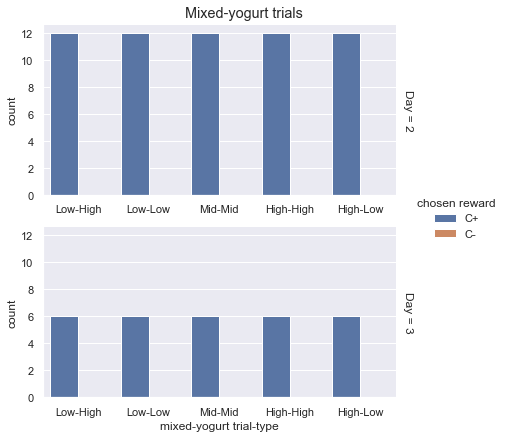

In [13]:
my_palette = [sns.color_palette("rocket")[1]] + 3 * [sns.color_palette("rocket")[3]] + [sns.color_palette("rocket")[1]] 

def get_mixedYogurt_trialType(row):
  if row['lottery p'] == row['reference p']:
    if row['lottery p'] == .13:
      trialType = 'Low-Low'
    elif row['lottery p'] == .5:
      trialType = 'Mid-Mid'
    elif row['lottery p'] == .75:
      trialType = 'High-High'
  elif row['lottery p'] > row['reference p']:
    trialType = 'Low-High'
  else:
    trialType = 'High-Low'
  return trialType

def get_cPlusChoices(group):
  cPlus_choices = len(group[group['choice'] == 1])
  return int(cPlus_choices)

neuroEcon_my_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt']
neuroEcon_my_df['mixed-yogurt trial-type'] = neuroEcon_my_df.apply(lambda row: get_mixedYogurt_trialType(row), axis = 1)
grouped_my_df = pd.DataFrame(neuroEcon_my_df.groupby(['Day', 'mixed-yogurt trial-type']).apply(lambda df: get_cPlusChoices(df)), 
        columns = ['C+ choice count']).reset_index()

sns.catplot(data= neuroEcon_my_df, row = 'Day', 
    x='mixed-yogurt trial-type', hue= 'chosen reward',
    kind = 'count', order = ['Low-High', 'Low-Low', 'Mid-Mid', 'High-High', 'High-Low'],
    hue_order = ['C+', 'C-'], 
    height=3, aspect = 2, palette= [cPlus_color, cMinus_color],
    sharex=False, margin_titles = True
    )

plt.suptitle('Mixed-yogurt trials', va = 'bottom');
plt.savefig(subject_figures_path_ + '/mixedYogurt_Choices.png')

# Mixed-type trials

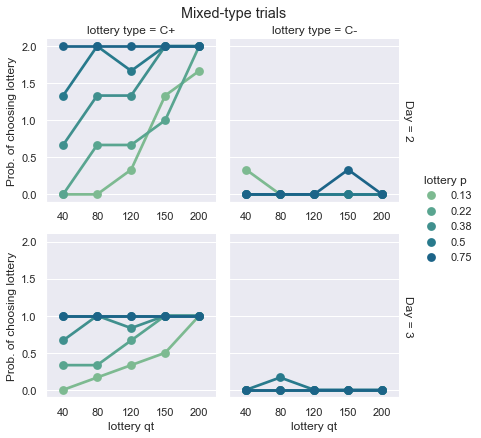

In [14]:
neuroEcon_mt_df = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed']

grouped_mt_df = pd.DataFrame(neuroEcon_mt_df.groupby(['Day', 'lottery type', 'lottery p', 'lottery qt']).apply(lambda df: get_probLottery(df)), 
        columns = [probLotteryChoice_colName]).reset_index()
sns.set_theme(font_scale = 1)

sns.catplot(data= grouped_mt_df, row = 'Day', col="lottery type", 
    x="lottery qt", y=probLotteryChoice_colName, hue="lottery p", 
    kind = 'point', palette = sns.color_palette("crest"),
    height=3, aspect = 1,
    sharex=False, margin_titles = True
    )
plt.suptitle('Mixed-type trials', va = 'bottom');
plt.savefig(subject_figures_path_ + '/mixedType_probPlots.png')